In [1]:
from keras.applications import ResNet50
from vis.utils import utils
from keras import activations
import warnings
warnings.filterwarnings('ignore')


model = ResNet50(weights='imagenet', include_top=True)

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'fc1000')

# Swap softmax with linear3
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

Using TensorFlow backend.


### Importing two images for classification

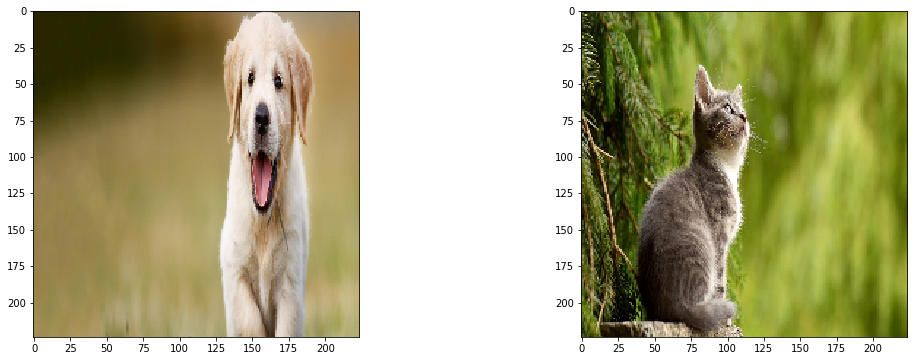

In [56]:
from vis.utils import utils
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

img1 = utils.load_img('test.jpg', target_size=(224, 224))
img2 = utils.load_img('test1.jpg', target_size=(224, 224))

f, ax = plt.subplots(1, 2)
ax[0].imshow(img1)
ax[1].imshow(img2)
plt.show()

## Lets see what the model predicts these two images as

In [48]:
import pandas as pd
index = pd.read_json("imagenet_class_index.json")

In [49]:
import numpy as np
img = []
img.append(img1)
img.append(img2)
img = np.array(img)
ans = model.predict(img)

In [50]:
index[np.argmax(ans[0])]

0          n02113799
1    standard_poodle
Name: 267, dtype: object

#### One as Standard poodle

In [51]:
index[np.argmax(ans[1])]

0       n02124075
1    Egyptian_cat
Name: 285, dtype: object

#### Other as Egyptian Cat. Stroing these in a list to produce mappings accordingly

In [57]:
# These are the index position of those classes
index_ = [267, 285]

## Visualizing Saliency maps 

-  Saliency map is generated by computing the change in output with respect to the change in the input image.
-  This can be obtained by taking the gradient of output w.r.t input.
-  The guided method backprop modifies backprop to only propagate positive gradients for positive activations.
-  Relu method modifies backprop to only propagate positive gradients.

<Figure size 720x720 with 0 Axes>

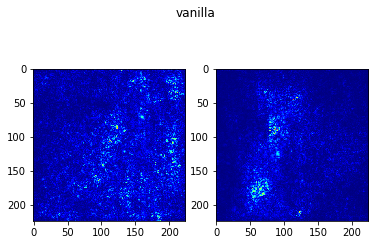

<Figure size 720x720 with 0 Axes>

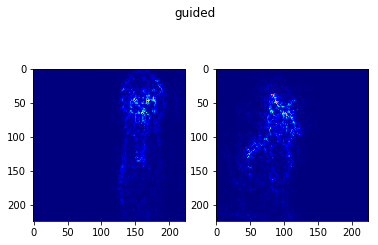

<Figure size 720x720 with 0 Axes>

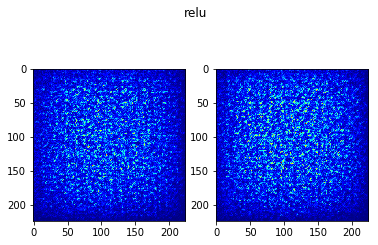

In [53]:
from vis.visualization import visualize_saliency
for modifier in [None, 'guided', 'relu']:
    plt.figure(figsize=(10, 10))
    f, ax = plt.subplots(1, 2)
    plt.suptitle("vanilla" if modifier is None else modifier)
    for i, img in enumerate([img1, img2]):    
        grads = visualize_saliency(model, layer_idx, filter_indices=index_[i], 
                                   seed_input=img, backprop_modifier=modifier)
        ax[i].imshow(grads, cmap='jet')

## Visualizing Class Activation Maps

- The Class Activation Maps is similar to saliency maps but way more efficient and correct.
- It takes the sum of the Conv layer before pooling and fully connected, weighted to the neurons to its respctive classes.
- GradCAM does the same thing but it takes the weight as the gradient of output w.r.t to images.

<Figure size 432x288 with 0 Axes>

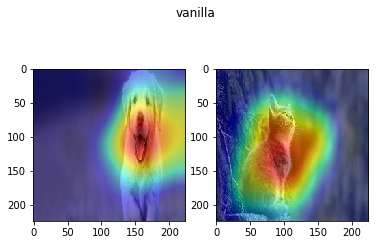

<Figure size 432x288 with 0 Axes>

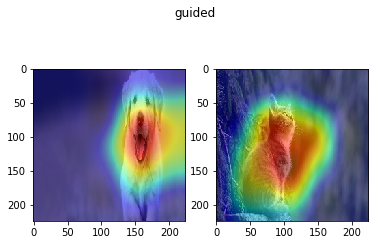

<Figure size 432x288 with 0 Axes>

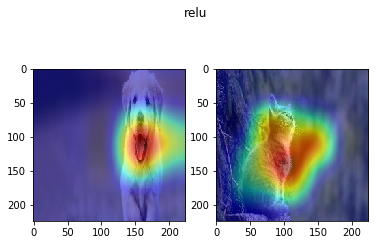

In [12]:
import numpy as np
import matplotlib.cm as cm
from vis.visualization import visualize_cam
from vis.visualization import overlay

penultimate_layer = utils.find_layer_idx(model, 'res5c_branch2c')

for modifier in [None, 'guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle("vanilla" if modifier is None else modifier)
    for i, img in enumerate([img1, img2]):    
        # 20 is the imagenet index corresponding to `ouzel`
        grads = visualize_cam(model, layer_idx, filter_indices=index_[i], 
                              seed_input=img, penultimate_layer_idx=penultimate_layer,
                              backprop_modifier=modifier)        
        # Lets overlay the heatmap onto original image.    
        jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
        ax[i].imshow(overlay(jet_heatmap, img))

## Creating Image causing Maximum Activation for a certain class

- Here we take a random input image then try to maximize the output by changing the values.
- We implement Gradient Ascent to change the image to get the maximum output.

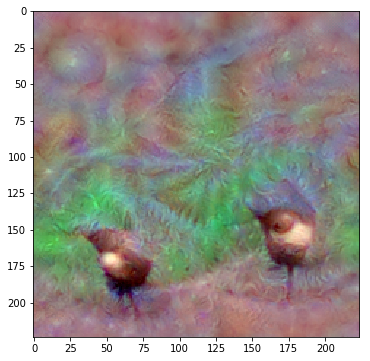

In [60]:
from vis.input_modifiers import Jitter
from vis.visualization import visualize_activation

img = visualize_activation(model, layer_idx, filter_indices=20, max_iter=3000, input_modifiers=[Jitter(16)])
plt.imshow(img)

#### This is for a bird Water Ouzel

## Putting in a random image to see the output

In [35]:
img3 = np.random.rand(224, 224, 3)

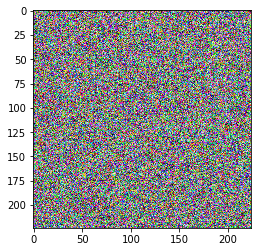

In [46]:
plt.imshow(img3)

In [265]:
grads = visualize_saliency(model, layer_idx, filter_indices=999, 
                                   seed_input=img3, backprop_modifier='guided')


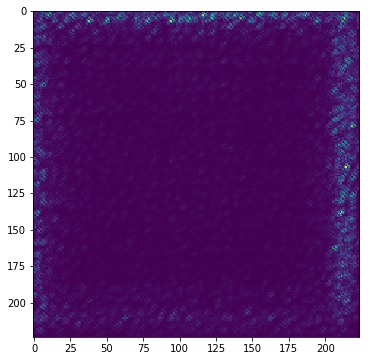

In [266]:
plt.imshow(grads)

### Setting a threshold for clear visualization

In [267]:
for i in range(224):
    for j in range(224):
        if grads[i, j] > 0.02:
            grads[i, j] = 1 
        else:
            grads[i, j] = 0

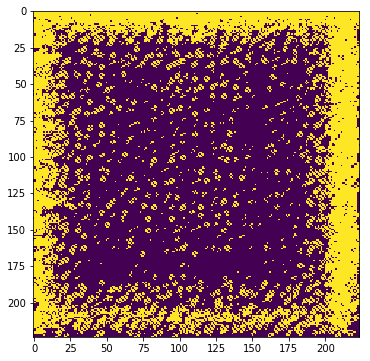

In [268]:
plt.imshow(grads)

## In the following cases looks like the saliency map for is the same for any class unlike CAMs

### Even for random classes it produces the same saliency map

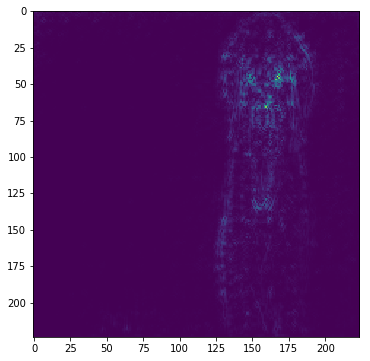

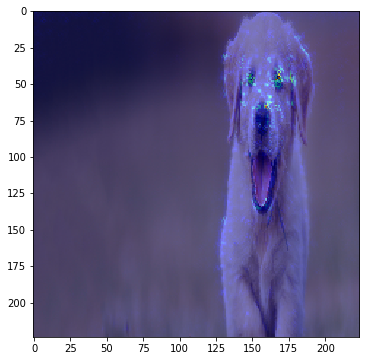

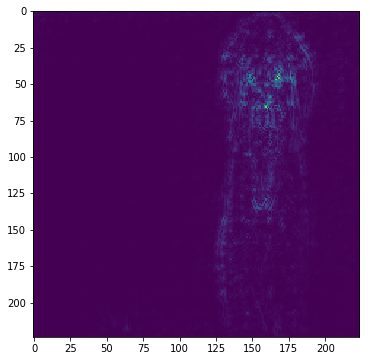

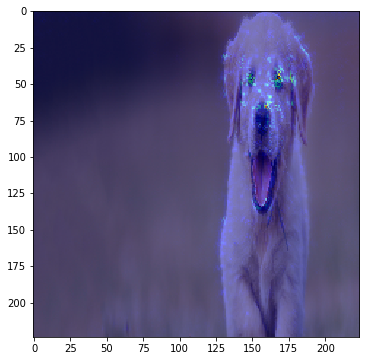

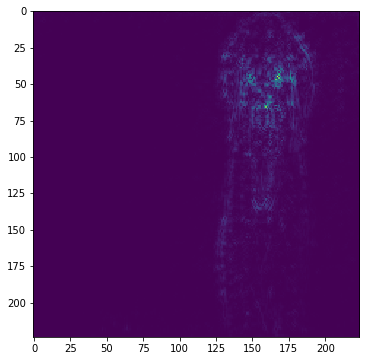

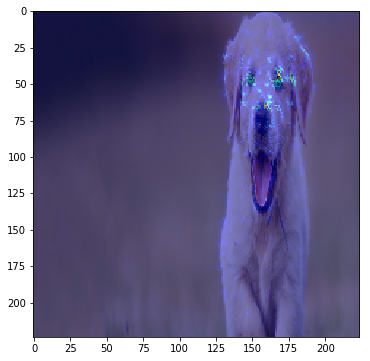

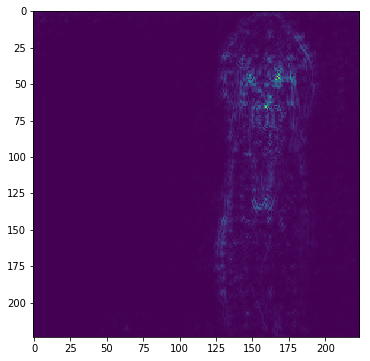

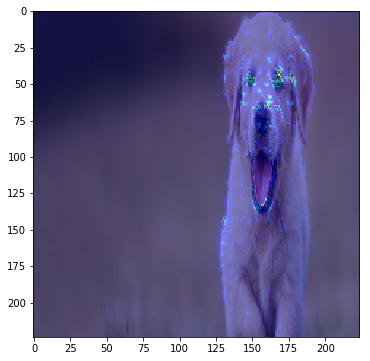

In [272]:
for i in [1, 100, 256, 678]:
    grads = visualize_saliency(model, layer_idx, filter_indices=i, 
                                       seed_input=img1, backprop_modifier='guided')

    plt.imshow(grads)
    plt.show()

    plt.imshow(overlay(img1, np.uint8(cm.jet(grads)[..., :3] * 255)))
    plt.show()

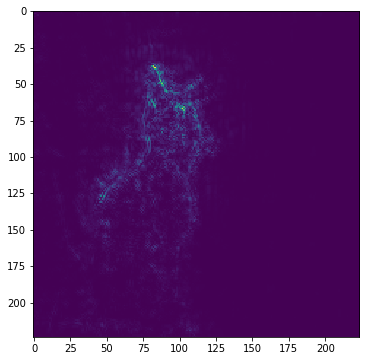

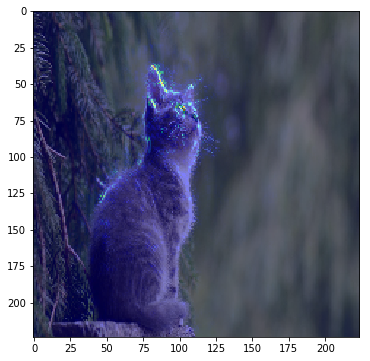

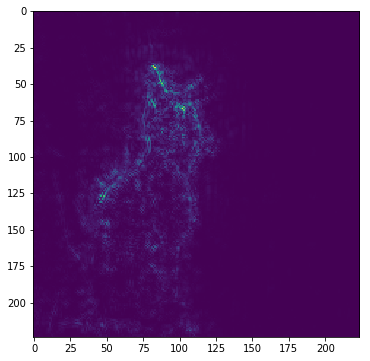

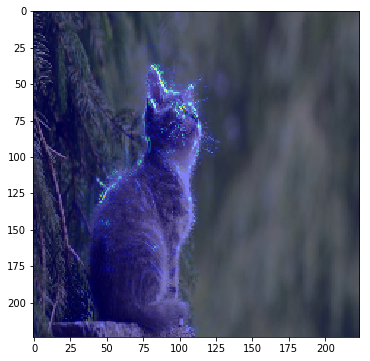

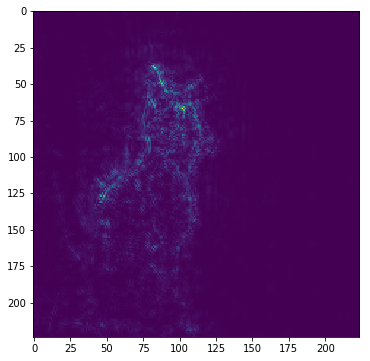

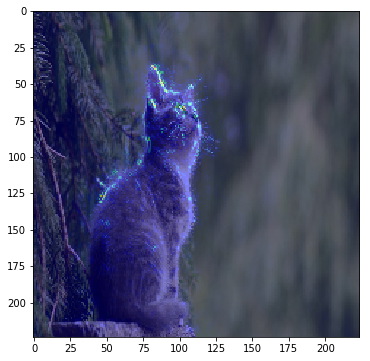

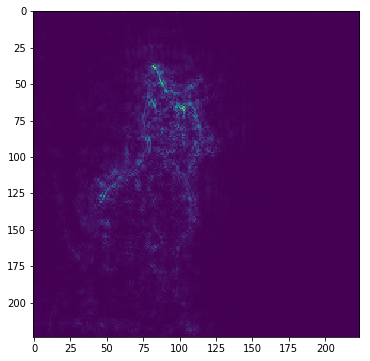

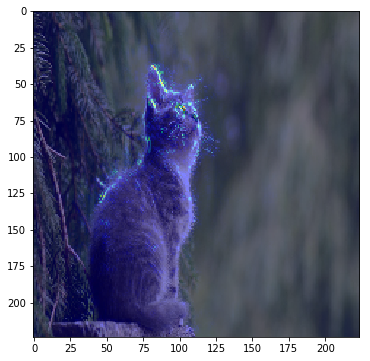

In [273]:
for i in [1, 100, 256, 678]:
    grads = visualize_saliency(model, layer_idx, filter_indices=i, 
                                       seed_input=img2, backprop_modifier='guided')

    plt.imshow(grads)
    plt.show()

    plt.imshow(overlay(img2, np.uint8(cm.jet(grads)[..., :3] * 255)))
    plt.show()

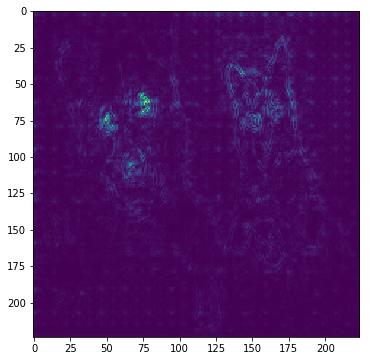

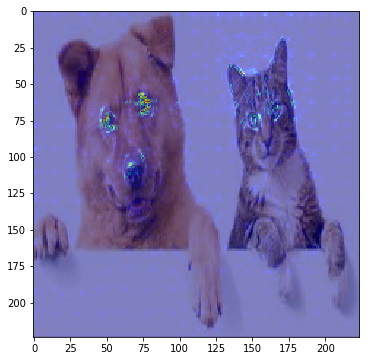

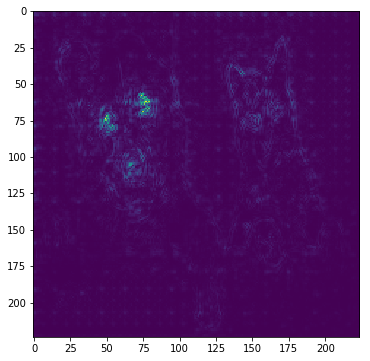

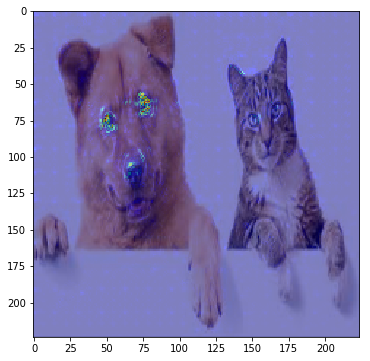

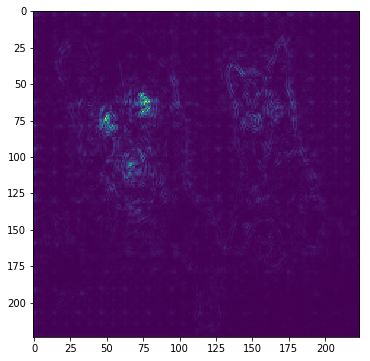

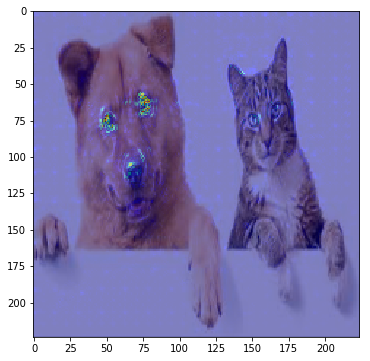

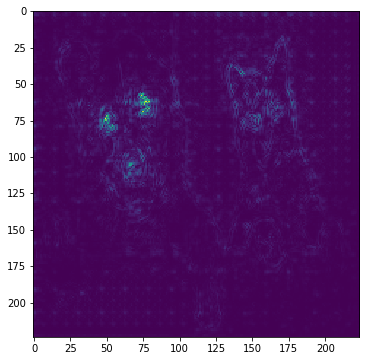

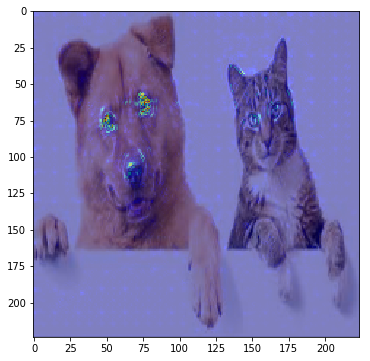

In [276]:
img3 = utils.load_img('download.jfif', target_size=(224, 224))
for i in [1, 100, 256, 678]:
    grads = visualize_saliency(model, layer_idx, filter_indices=i, 
                                       seed_input=img3, backprop_modifier='guided')

    plt.imshow(grads)
    plt.show()

    plt.imshow(overlay(img3, np.uint8(cm.jet(grads)[..., :3] * 255)))
    plt.show()

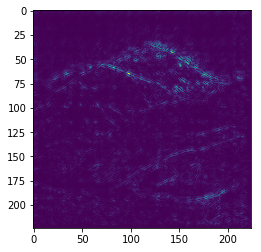

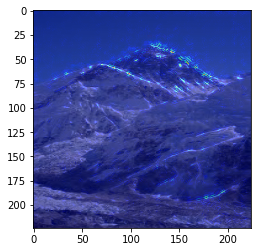

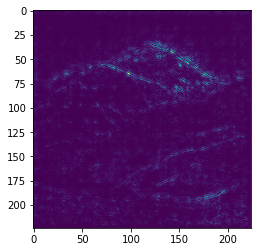

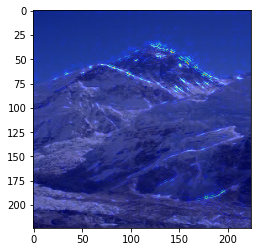

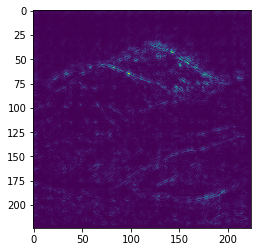

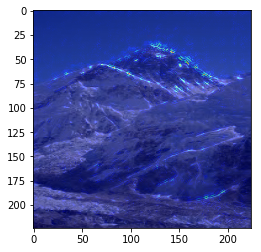

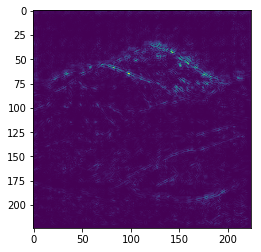

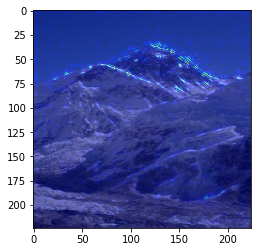

In [22]:
img4 = utils.load_img('everest.jfif', target_size=(224, 224))
for i in [1, 100, 256, 678]:
    grads = visualize_saliency(model, layer_idx, filter_indices=i, 
                                       seed_input=img4, backprop_modifier='guided')

    plt.imshow(grads)
    plt.show()

    plt.imshow(overlay(img4, np.uint8(cm.jet(grads)[..., :3] * 255)))
    plt.show()

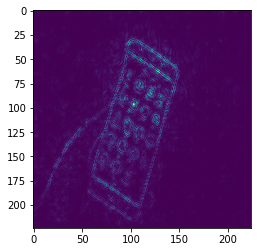

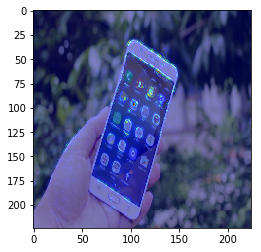

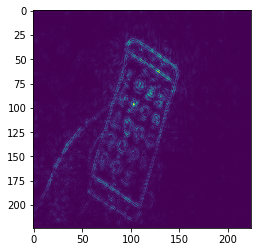

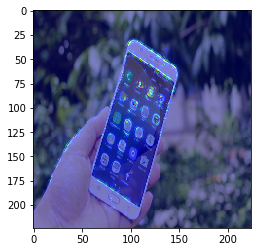

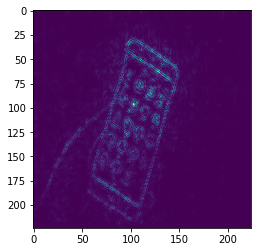

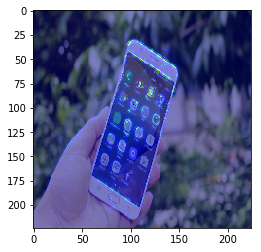

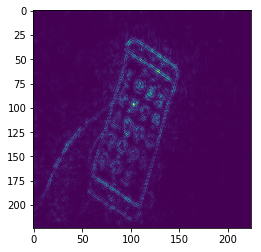

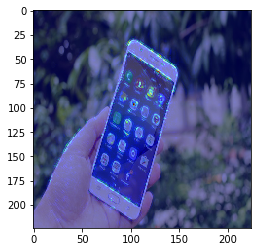

In [24]:
img5 = utils.load_img('cell.jpg', target_size=(224, 224))
for i in [1, 100, 256, 678]:
    grads = visualize_saliency(model, layer_idx, filter_indices=i, 
                                       seed_input=img5, backprop_modifier='guided')

    plt.imshow(grads)
    plt.show()

    plt.imshow(overlay(img5, np.uint8(cm.jet(grads)[..., :3] * 255)))
    plt.show()